In [12]:
# pip install --quiet scvi-tools

In [13]:
# !pip install scDREAMER
import scDREAMER

In [14]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
# import scib
# import louvain

In [15]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [16]:
import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [17]:
# setting seed for reproducibility
np.random.seed(666)
tf.set_random_seed(666)
random.seed(666)
tf2.random.set_seed(666)
tf2.keras.utils.set_random_seed(666)

In [18]:
import anndata
adata = anndata.read_h5ad("../human_pancreas_norm.h5ad")
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [19]:
adata.obs['cell_type'] = adata.obs['celltype']
adata.obs['batch'] = adata.obs['tech']
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_type', 'batch'
    layers: 'counts'

### For scDREAMER, missing should be NA instead of unknown; for ItClust, no NA should be included.

In [20]:
# load the prediction results to adata
predict_labels = pd.read_csv("../R_human_pancreas/labels/azimuth_human_pancreas_predictions.csv")

adata.obs['celltype'] = predict_labels['x'].values

In [21]:
# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'celltype']].head()

,batch,cell_type,celltype
D101_5,celseq,gamma,gamma
D101_43,celseq,gamma,gamma
D101_93,celseq,gamma,gamma
D102_4,celseq,gamma,gamma
D172444_23,celseq,gamma,gamma


In [22]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('./labels_for_new_methods/azimuth_human_pancreas_obs.csv')

In [23]:
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_type', 'batch'
    layers: 'counts'

In [24]:
adata.write('./labels_for_new_methods/human_pancreas_azimuth.h5ad')

In [25]:
embeddings_dict = {}

## scDREAMER
scDREAMER takes h5ad file directly as input.


Leaning rate to use for small data vs large input data: 
learning_rate = {
    "Immune_Human": {"lr_ae": 0.0002, "lr_dis": 0.0007},  # Small Datasets
    "Human_Mouse": {"lr_ae": 0.0001, "lr_dis": 0.00001},
}  # Big Datasets >= 0.5 million cells

it does the data preprocessing by its own function: 
	•	read_h5ad: This function reads the data from an .h5ad file using Scanpy and performs several preprocessing steps:
	•	Normalization: Total counts per cell are normalized to 10,000.
	•	Log Transformation: A log transformation is applied to the data.
	•	Highly Variable Genes: The top 2,000 highly variable genes are selected based on the Seurat method, using the batch key for batch correction.
	•	Data Preparation: The data is then converted into a dense or sparse matrix, depending on sparseIP.
	•	One-Hot Encoding: Batch information and cell type labels are one-hot encoded, which will be used later in the model.
	•	load_gene_mtx: This function loads the dataset, processes it using read_h5ad, and prepares it for input into the model. It handles transformations, normalization, and returns the processed data along with labels and batch information.

Loading dataset
Preprocessing...
here [9 9 9 ... 9 9 9]
Shape self.data_train: (16382, 2000)
Shape self.data_test: (16382, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2009), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 19), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ./labels_for_new_methods/human_pancreas_azimuth.h5ad ... 
Epoch : [0] ,  a_loss = 701.7405
Epoch : [10] ,  a_loss = 547.5970
Epoch : [20] ,  a_loss = 526.9733
Epoch : [30] ,  a_loss = 515.0979
Epoch : [40] ,  a_loss = 506.3864

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


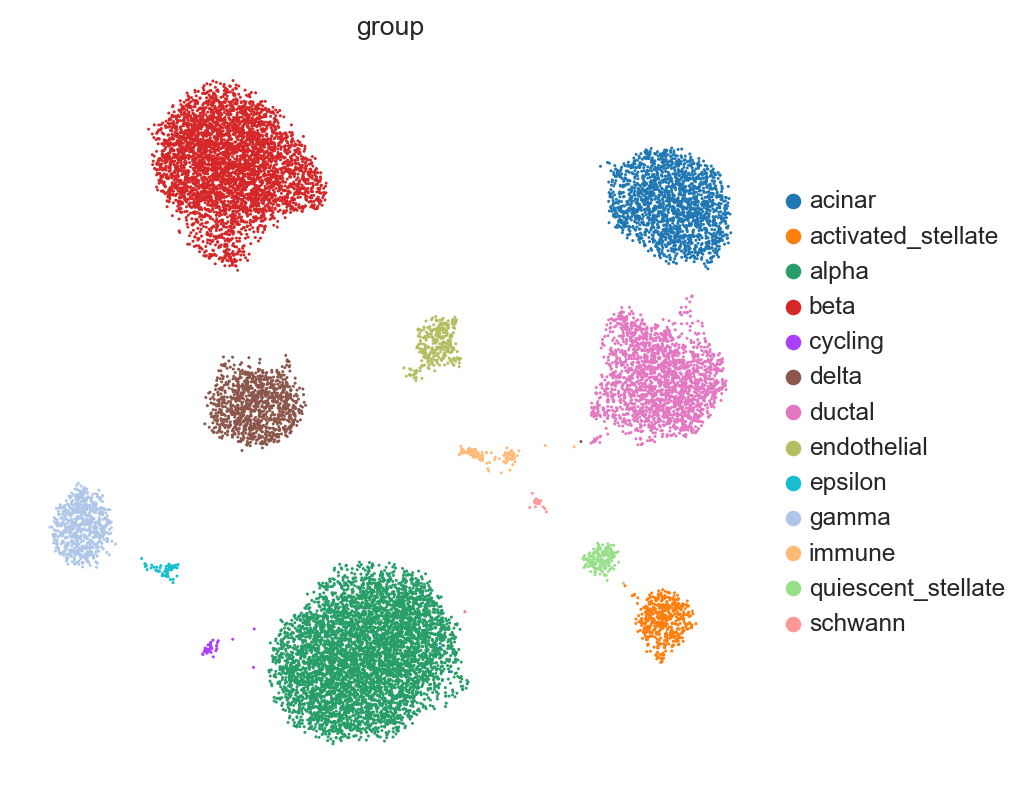

None


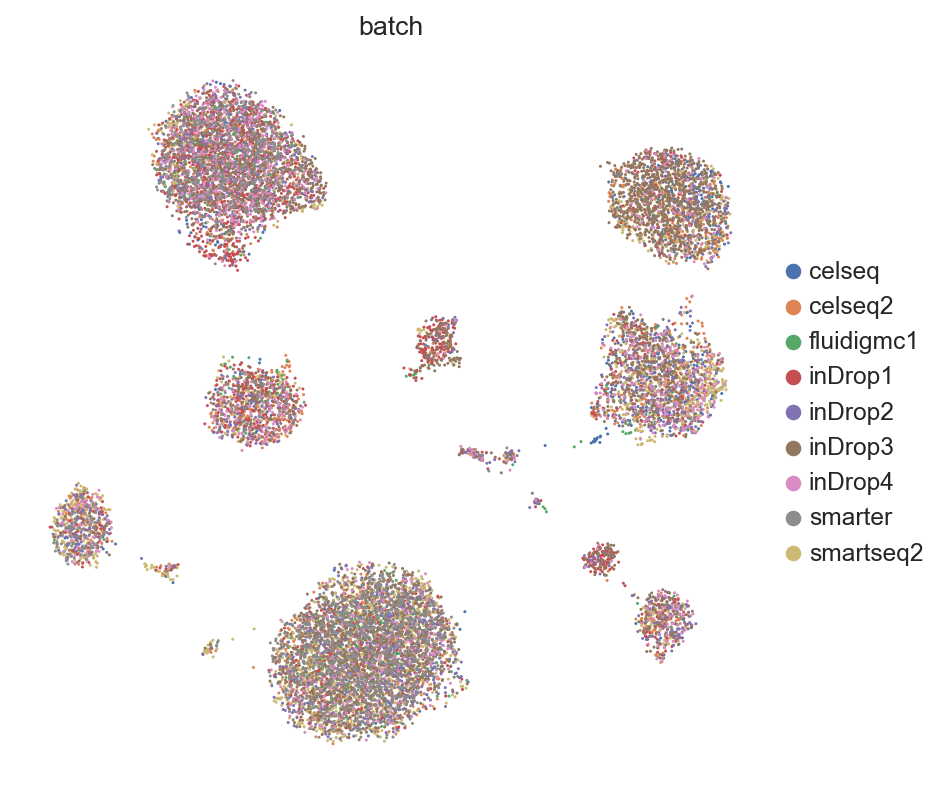

None


In [26]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "human_pancreas_azimuth"
dataset_path = "./labels_for_new_methods/human_pancreas_azimuth.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=200,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()

In [27]:
import pandas as pd
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/azimuth_scdreamer_embeddings_human_pancreas.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [28]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = adata.obsm['X_scDREAMER']

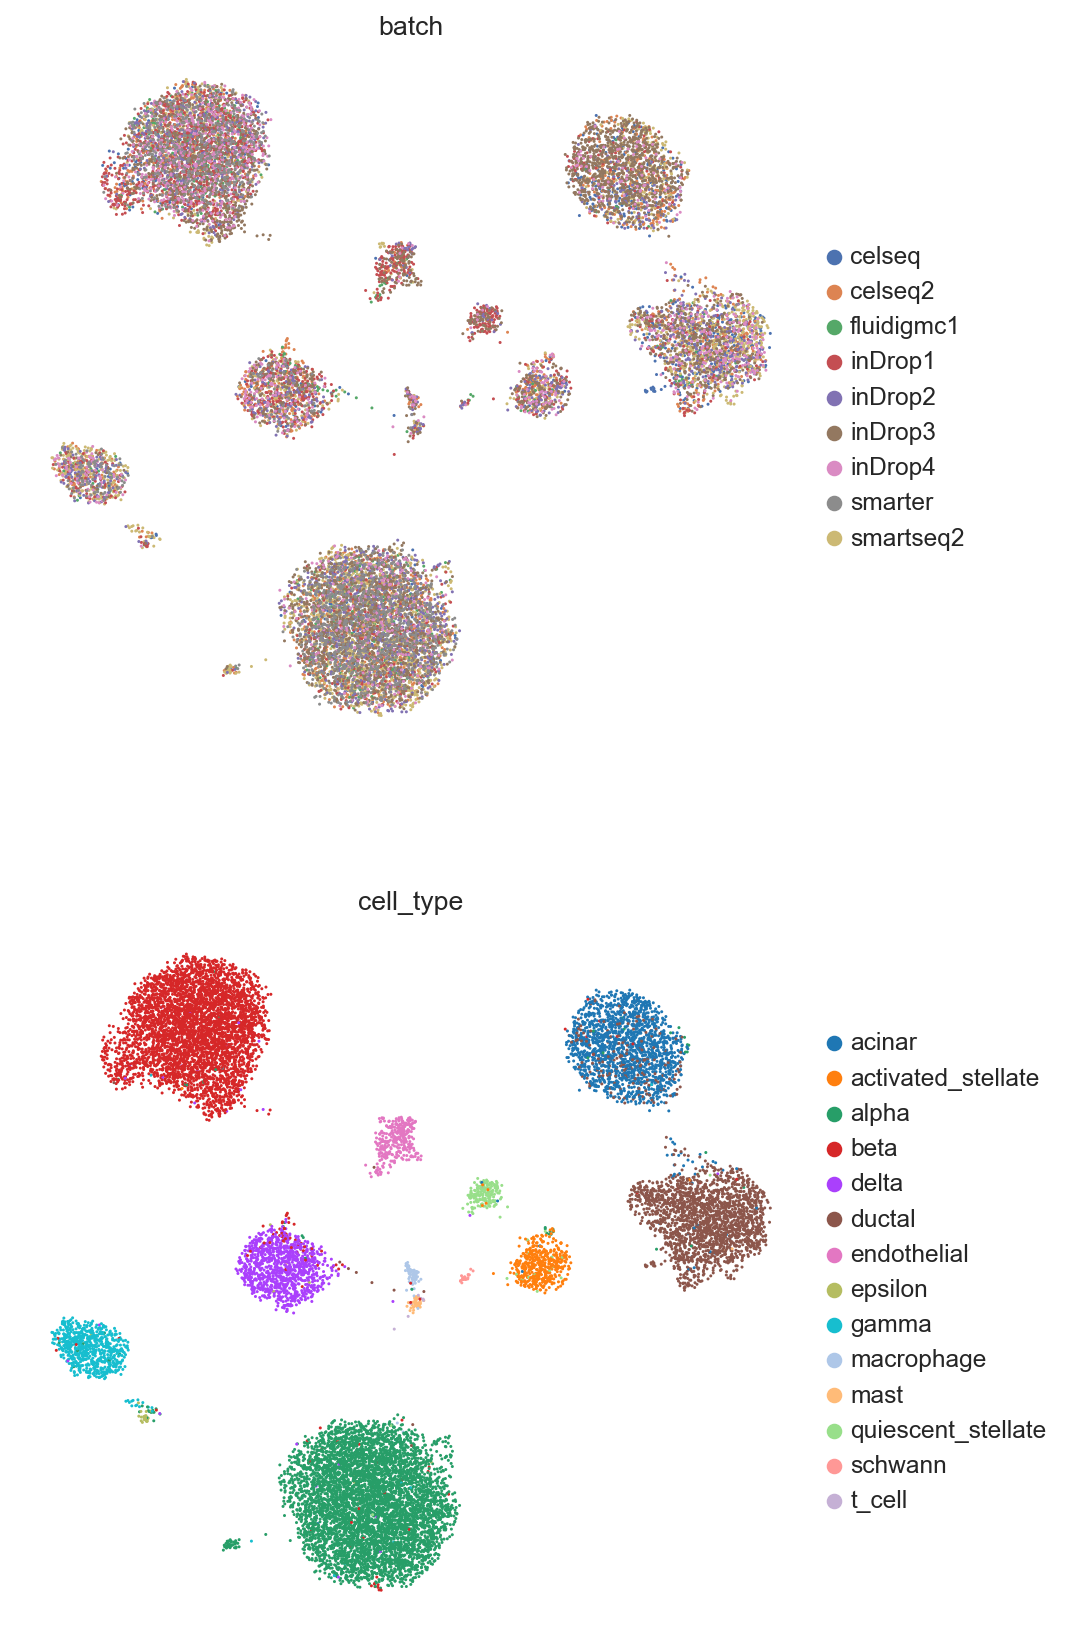

In [29]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# ItClust

In [30]:
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/azimuth_human_pancreas_itclust_embeddings.csv', index_col=0)
adata.obsm['X_ItClust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_ItClust")
sc.tl.umap(adata, min_dist=0.5)

In [31]:
# Collect embeddings
embeddings_dict["X_ItClust"] = adata.obsm['X_ItClust']

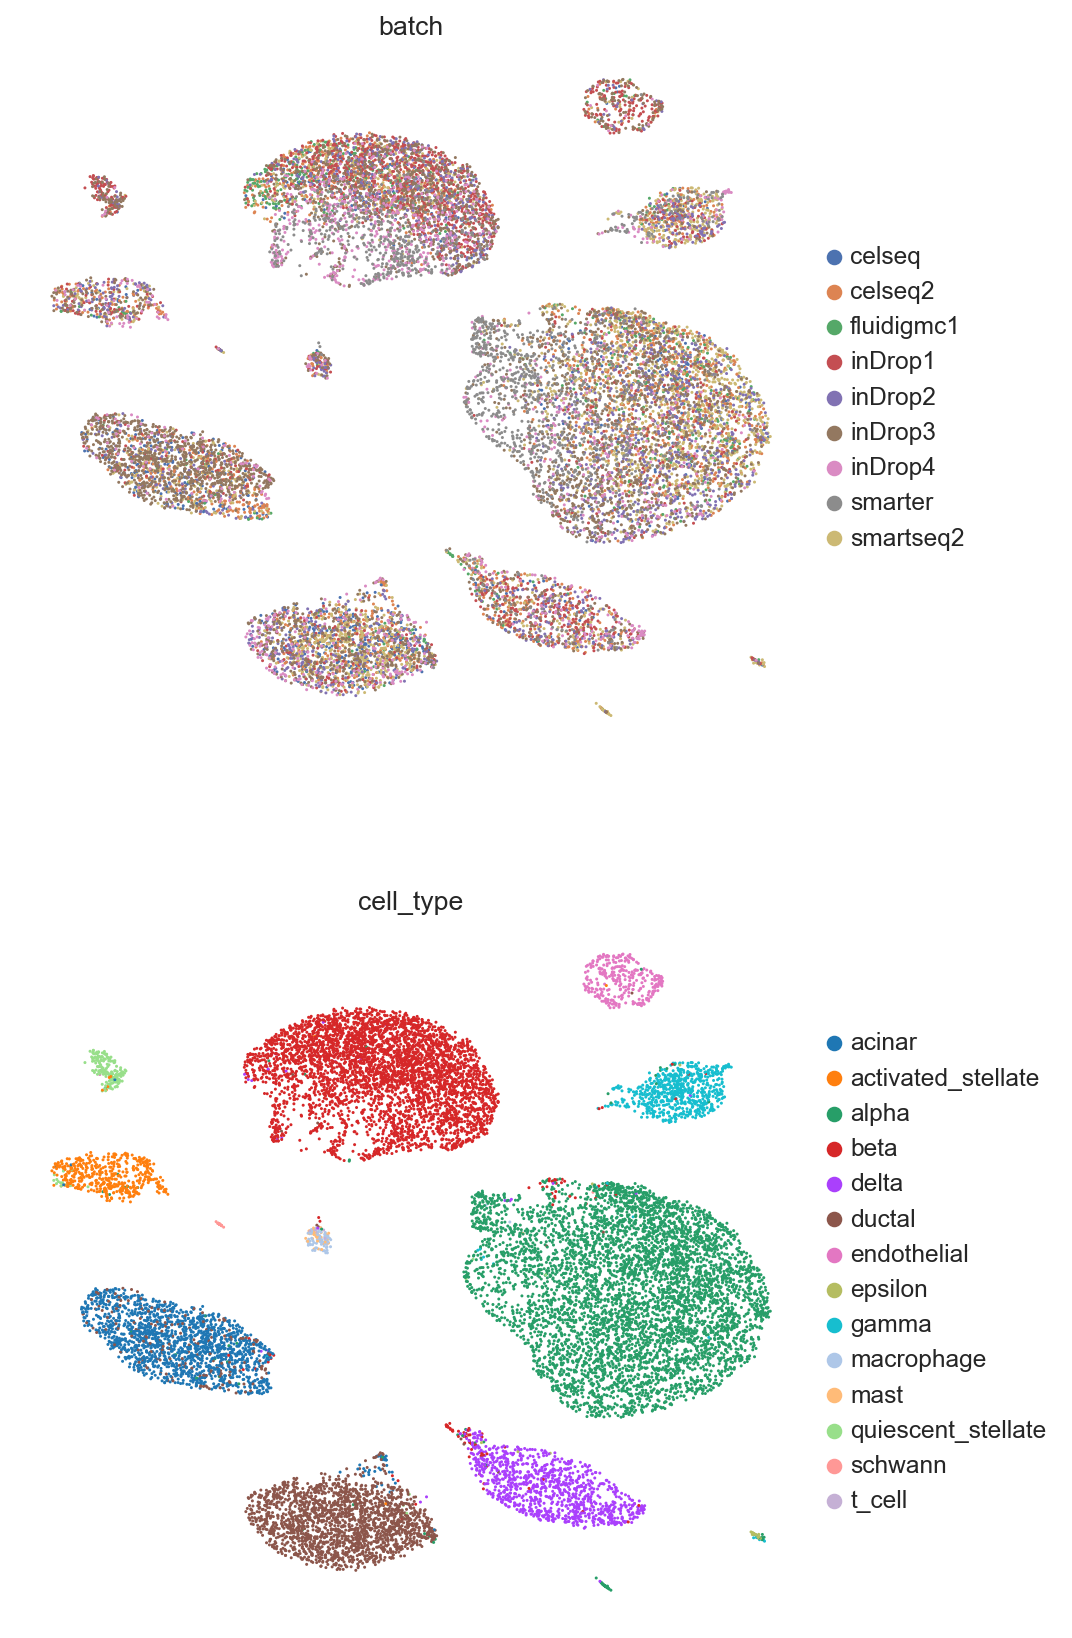

In [32]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [33]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./azimuth_human_pancreas_new.csv")
